In [54]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import os
import pydicom
import re

In [4]:
train = pd.read_csv('../train.csv')
test = pd.read_csv('../test.csv')

print("Total Recordings in Train Data: {:,}".format(len(train)))
print("Total Recordings in Test Data: {:,}".format(len(test)))

Total Recordings in Train Data: 1,549
Total Recordings in Test Data: 5


In [5]:
print("Q: Are there any missing values?", "\n" +
      "A: {}".format(train.isnull().values.any()))

Q: Are there any missing values? 
A: False


There are 176 unique patients in Train Data. 

Minimum number of entries are: 6 
Maximum number of entries are: 10


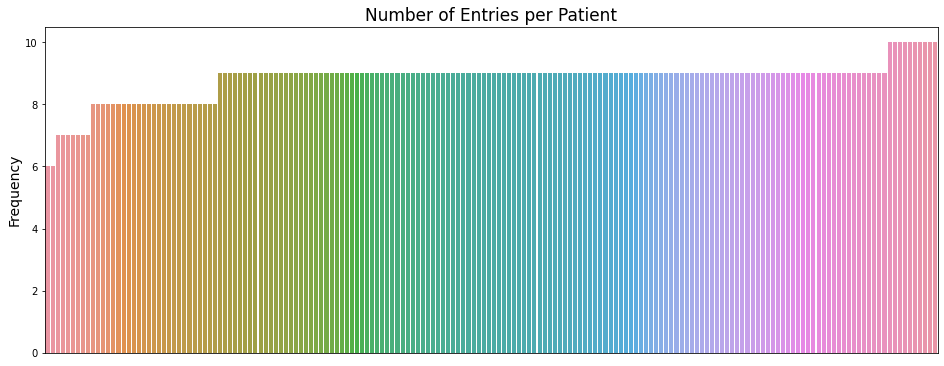

In [12]:
print("There are {} unique patients in Train Data.".format(len(train["Patient"].unique())), "\n")

# Recordings per Patient
data = train.groupby(by="Patient")["Weeks"].count().reset_index(drop=False)
# Sort by Weeks
data = data.sort_values(['Weeks']).reset_index(drop=True)

print("Minimum number of entries are: {}".format(data["Weeks"].min()), "\n" +
      "Maximum number of entries are: {}".format(data["Weeks"].max()))

# Plot
plt.figure(figsize = (16, 6))
p = sns.barplot(data["Patient"], data["Weeks"])

plt.title("Number of Entries per Patient", fontsize = 17)
plt.xlabel('Patient', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

p.axes.get_xaxis().set_visible(False);

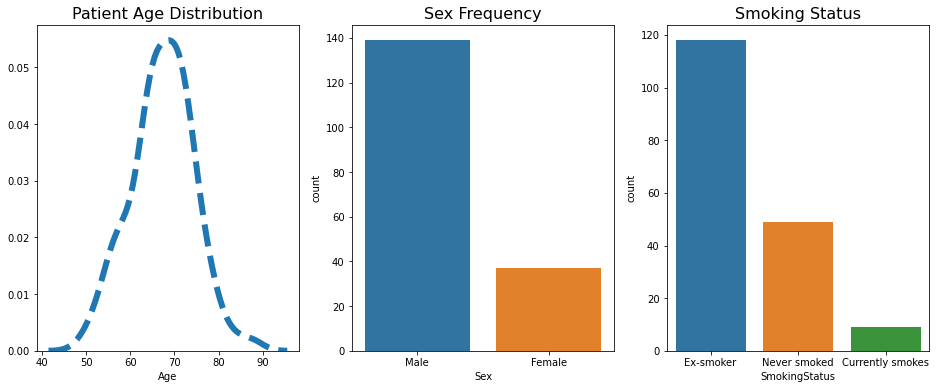

In [21]:
# Select unique bio info for the patients
data = train.groupby(by="Patient")[["Patient", "Age", "Sex", "SmokingStatus"]].first().reset_index(drop=True)

# Figure
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16, 6))

a = sns.distplot(data["Age"], ax=ax1,  hist=False, kde_kws=dict(lw=6, ls="--"))
b = sns.countplot(data["Sex"], ax=ax2)
c = sns.countplot(data["SmokingStatus"], ax=ax3)

a.set_title("Patient Age Distribution", fontsize=16)
b.set_title("Sex Frequency", fontsize=16)
c.set_title("Smoking Status", fontsize=16);

Min FVC value: 827 
Max FVC value: 6,399 

Min Percent value: 28.88% 
Max Percent value: 153.1%


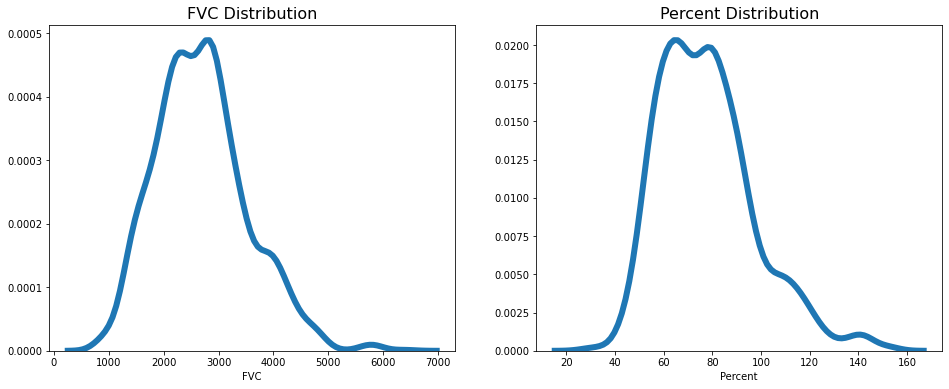

In [29]:
print("Min FVC value: {:,}".format(train["FVC"].min()), "\n" +
      "Max FVC value: {:,}".format(train["FVC"].max()), "\n" +
      "\n" +
      "Min Percent value: {:.4}%".format(train["Percent"].min()), "\n" +
      "Max Percent value: {:.4}%".format(train["Percent"].max()))

# Figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

a = sns.distplot(train["FVC"], ax=ax1,  hist=False, kde_kws=dict(lw=6, ls="-"))
b = sns.distplot(train["Percent"], ax=ax2,  hist=False, kde_kws=dict(lw=6, ls="-"))

a.set_title("FVC Distribution", fontsize=16)
b.set_title("Percent Distribution", fontsize=16);

Minimum no. weeks before CT: -5 
Maximum no. weeks after CT: 133


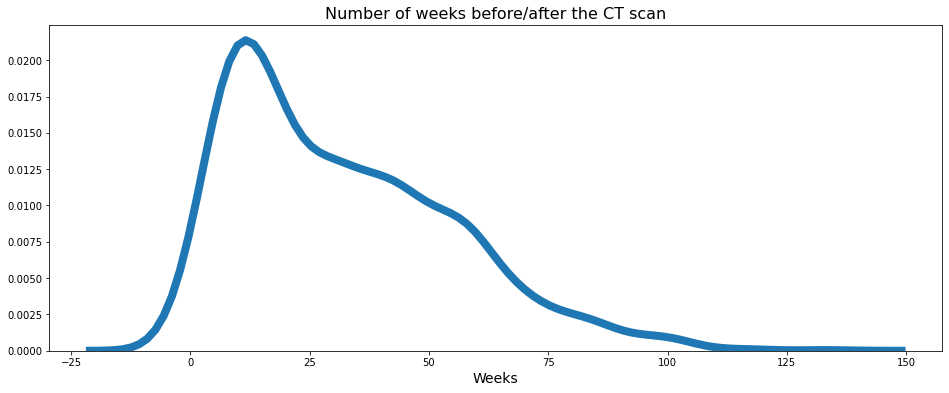

In [34]:
print("Minimum no. weeks before CT: {}".format(train['Weeks'].min()), "\n" +
      "Maximum no. weeks after CT: {}".format(train['Weeks'].max()))

plt.figure(figsize = (16, 6))

a = sns.distplot(train['Weeks'],  hist=False, kde_kws=dict(lw=8, ls="-"))
plt.title("Number of weeks before/after the CT scan", fontsize = 16)
plt.xlabel("Weeks", fontsize=14);

Pearson Corr FVC x Percent: 0.672 
Pearson Corr FVC x Age: -0.09 
Pearson Corr Percent x Age: 0.096


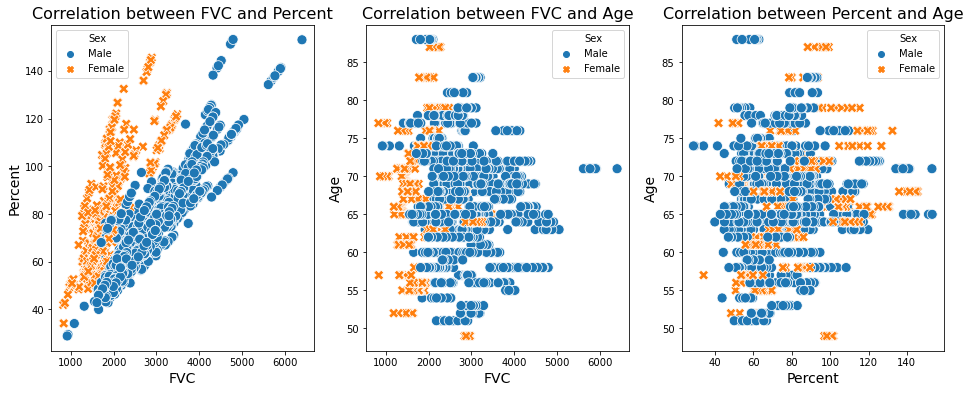

In [38]:
# Compute Correlation
corr1, _ = pearsonr(train["FVC"], train["Percent"])
corr2, _ = pearsonr(train["FVC"], train["Age"])
corr3, _ = pearsonr(train["Percent"], train["Age"])
print("Pearson Corr FVC x Percent: {:.4}".format(corr1), "\n" +
      "Pearson Corr FVC x Age: {:.0}".format(corr2), "\n" +
      "Pearson Corr Percent x Age: {:.2}".format(corr3))

# Figure
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16, 6))

a = sns.scatterplot(x = train["FVC"], y = train["Percent"], 
                    hue = train["Sex"], style = train["Sex"], s=100, ax=ax1)

b = sns.scatterplot(x = train["FVC"], y = train["Age"],  
                    hue = train["Sex"], style = train["Sex"], s=100, ax=ax2)

c = sns.scatterplot(x = train["Percent"], y = train["Age"], 
                    hue = train["Sex"], style = train["Sex"], s=100, ax=ax3)

a.set_title("Correlation between FVC and Percent", fontsize = 16)
a.set_xlabel("FVC", fontsize = 14)
a.set_ylabel("Percent", fontsize = 14)

b.set_title("Correlation between FVC and Age", fontsize = 16)
b.set_xlabel("FVC", fontsize = 14)
b.set_ylabel("Age", fontsize = 14)

c.set_title("Correlation between Percent and Age", fontsize = 16)
c.set_xlabel("Percent", fontsize = 14)
c.set_ylabel("Age", fontsize = 14);

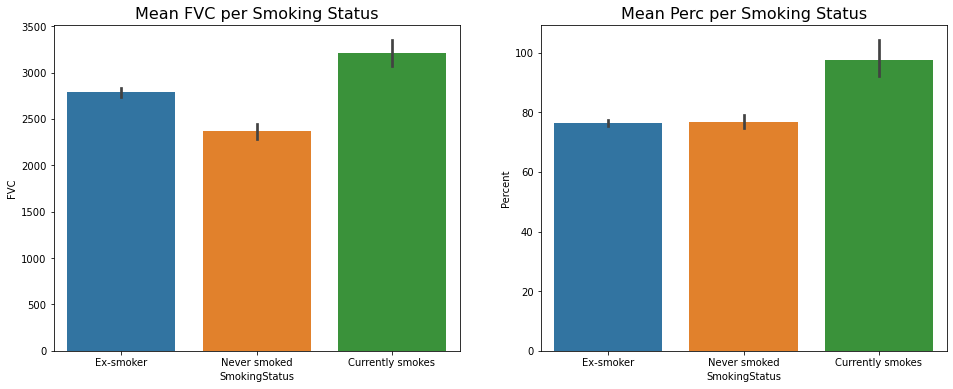

In [39]:
# Figure
f, (ax1, ax2) = plt.subplots(1,2, figsize = (16, 6))

a = sns.barplot(x = train["SmokingStatus"], y = train["FVC"], ax=ax1)
b = sns.barplot(x = train["SmokingStatus"], y = train["Percent"], ax=ax2)

a.set_title("Mean FVC per Smoking Status", fontsize=16)
b.set_title("Mean Perc per Smoking Status", fontsize=16);

In [41]:
# Create Time variable to count in ascending order the times the Patient has done a check in FVC
data_time = train.groupby(by="Patient")["Weeks"].count().reset_index()
train["Time"] = 0

for patient, times in zip(data_time["Patient"], data_time["Weeks"]):
    train.loc[train["Patient"] == patient, 'Time'] = range(1, times+1)

In [42]:
# For graph purposes, keep only Patients that had a big difference in FVC between Time 1 and last Time
min_fvc = train[train["Time"] == 1][["Patient", "FVC"]].reset_index(drop=True)

idx = train.groupby(["Patient"])["Weeks"].transform(max) == train["Weeks"]
max_fvc = train[idx][["Patient", "FVC"]].reset_index(drop=True)

# Compute difference and select only top patients with biggest difference
data = pd.merge(min_fvc, max_fvc, how="inner", on="Patient")
data["Dif"] = data["FVC_x"] - data["FVC_y"]

# Select only top n
l = list(data.sort_values("Dif", ascending=False).head(100)["Patient"])
x = train[train["Patient"].isin(l)]

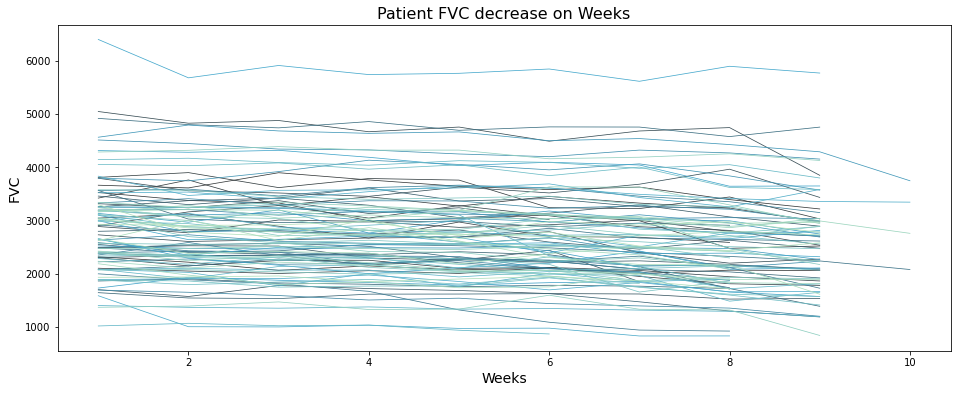

In [43]:
plt.figure(figsize = (16, 6))

a = sns.lineplot(x = x["Time"], y = x["FVC"], hue = x["Patient"], legend=False,
                 palette=sns.color_palette("GnBu_d", 100), size=1)

plt.title("Patient FVC decrease on Weeks", fontsize = 16)
plt.xlabel("Weeks", fontsize=14)
plt.ylabel("FVC", fontsize=14);

In [46]:
# Create base director for Train .dcm files
director = "../train"

# Create path column with the path to each patient's CT
train["Path"] = director + "/" + train["Patient"]

# Create variable that shows how many CT scans each patient has
train["CT_number"] = 0

for k, path in enumerate(train["Path"]):
    train["CT_number"][k] = len(os.listdir(path))

c:\users\user\anaconda3.1\envs\gpu\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Minimum number of CT scans: 12 
Maximum number of CT scans: 1,018


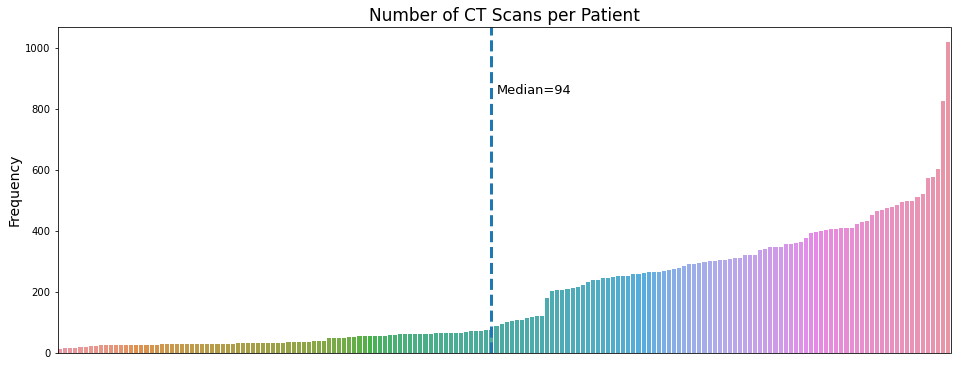

In [48]:
print("Minimum number of CT scans: {}".format(train["CT_number"].min()), "\n" +
      "Maximum number of CT scans: {:,}".format(train["CT_number"].max()))

# Scans per Patient
data = train.groupby(by="Patient")["CT_number"].first().reset_index(drop=False)
# Sort by Weeks
data = data.sort_values(['CT_number']).reset_index(drop=True)

# Plot
plt.figure(figsize = (16, 6))
p = sns.barplot(data["Patient"], data["CT_number"])
plt.axvline(x=85, linestyle='--', lw=3)

plt.title("Number of CT Scans per Patient", fontsize = 17)
plt.xlabel('Patient', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.text(86, 850, "Median=94", fontsize=13)

p.axes.get_xaxis().set_visible(False);

In [51]:
class bcolors:
    OKBLUE = '\033[96m'
    OKGREEN = '\033[92m'

Patient id.......: ID00007637202177411956430 
Modality.........: CT 
Rows.............: 512 
Columns..........: 512


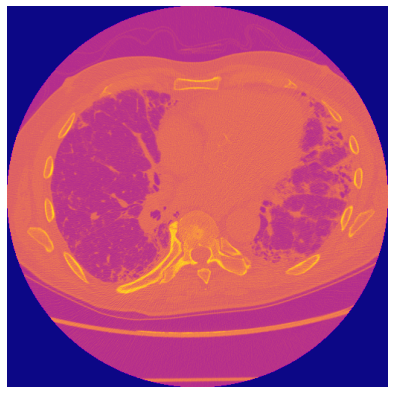

In [52]:
path = "../train/ID00007637202177411956430/19.dcm"
dataset = pydicom.dcmread(path)

print(bcolors.OKBLUE + "Patient id.......:", dataset.PatientID, "\n" +
      "Modality.........:", dataset.Modality, "\n" +
      "Rows.............:", dataset.Rows, "\n" +
      "Columns..........:", dataset.Columns)

plt.figure(figsize = (7, 7))
plt.imshow(dataset.pixel_array, cmap="plasma")
plt.axis('off');

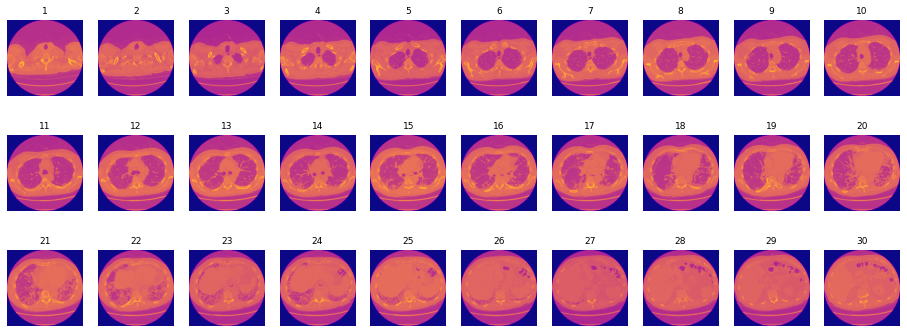

In [55]:
patient_dir = "../train/ID00007637202177411956430"
datasets = []

# First Order the files in the dataset
files = []
for dcm in list(os.listdir(patient_dir)):
    files.append(dcm) 
files.sort(key=lambda f: int(re.sub('\D', '', f)))

# Read in the Dataset
for dcm in files:
    path = patient_dir + "/" + dcm
    datasets.append(pydicom.dcmread(path))

# Plot the images
fig=plt.figure(figsize=(16, 6))
columns = 10
rows = 3

for i in range(1, columns*rows +1):
    img = datasets[i-1].pixel_array
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="plasma")
    plt.title(i, fontsize = 9)
    plt.axis('off');

In [56]:
from PIL import Image
from IPython.display import Image as show_gif
import scipy.misc
import matplotlib